In [98]:
import tensorflow as tf

In [99]:
# helper functions

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

    
# plot loss & acc curves from the model.history
def plot_loss_acc_curves(history):
  """
  Returns separate loss/acc curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Get the class names (programmatically, this is much more helpful with a longer list of classes)
def get_class_names(path):
  data_dir = pathlib.Path(path)
  class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
  return class_names

In [100]:
# global variables
NUM_CLASSES = 2
IMAGE_SIZE = (224, 224)
COLOUR_CHANNELS = 3
dataset_dir = '/kaggle/input/dogs-vs-cats/dataset/'
train_dir = '/kaggle/input/dogs-vs-cats/dataset/train/'
test_dir = '/kaggle/input/dogs-vs-cats/dataset/test/'
validation_dir = '/kaggle/input/dogs-vs-cats/dataset/validation/'

walk_through_dir(dataset_dir)

There are 3 directories and 0 images in '/kaggle/input/dogs-vs-cats/dataset/'.
There are 2 directories and 0 images in '/kaggle/input/dogs-vs-cats/dataset/validation'.
There are 0 directories and 2500 images in '/kaggle/input/dogs-vs-cats/dataset/validation/dogs'.
There are 0 directories and 2500 images in '/kaggle/input/dogs-vs-cats/dataset/validation/cats'.
There are 2 directories and 0 images in '/kaggle/input/dogs-vs-cats/dataset/test'.
There are 0 directories and 6219 images in '/kaggle/input/dogs-vs-cats/dataset/test/dogs'.
There are 0 directories and 6242 images in '/kaggle/input/dogs-vs-cats/dataset/test/cats'.
There are 2 directories and 0 images in '/kaggle/input/dogs-vs-cats/dataset/train'.
There are 0 directories and 10000 images in '/kaggle/input/dogs-vs-cats/dataset/train/dogs'.
There are 0 directories and 10000 images in '/kaggle/input/dogs-vs-cats/dataset/train/cats'.


In [101]:
# get the class names from directory
class_names = get_class_names(train_dir)
print(class_names)

['cats' 'dogs']


In [102]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# preprocess the data into image datasets

train_data = image_dataset_from_directory(train_dir,
                                          label_mode='binary',
                                          image_size=IMAGE_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode='binary',
                                         image_size=IMAGE_SIZE)

validation_data = image_dataset_from_directory(validation_dir,
                                               label_mode='binary',
                                               image_size=IMAGE_SIZE)

Found 20000 files belonging to 2 classes.
Found 12461 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [103]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

# pretrained model for feature extraction
efficientnet_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3))

# freeze the layers
efficientnet_model.trainable = False

In [104]:
from tensorflow.keras import layers 

# build Sequential Model
model = tf.keras.Sequential()
model.add(efficientnet_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# compile the Model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [105]:
# print model layers, output shape, params
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 5362340 (20.46 MB)
Trainable params: 131

In [106]:
# fit the model
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    validation_data=validation_data,
                    validation_steps=len(validation_data),
                    epochs=3)

Epoch 1/3


2024-02-05 17:58:31.808762: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 57s 80ms/step - loss: 0.0400 - accuracy: 0.9874 - val_loss: 0.0291 - val_accuracy: 0.9906
Epoch 2/3
625/625 [==============================] - 48s 76ms/step - loss: 0.0260 - accuracy: 0.9918 - val_loss: 0.0214 - val_accuracy: 0.9926
Epoch 3/3
625/625 [==============================] - 48s 76ms/step - loss: 0.0224 - accuracy: 0.9926 - val_loss: 0.0229 - val_accuracy: 0.9936


In [107]:
# how good is our model on unknown data?
model.evaluate(test_data)

390/390 [==============================] - 24s 60ms/step - loss: 0.0267 - accuracy: 0.9933


[0.02670477144420147, 0.9933392405509949]

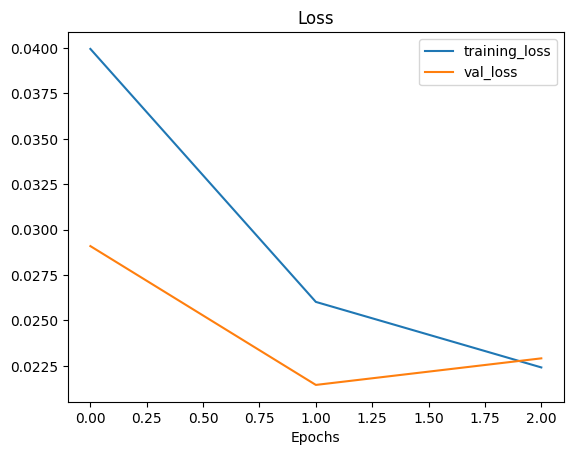

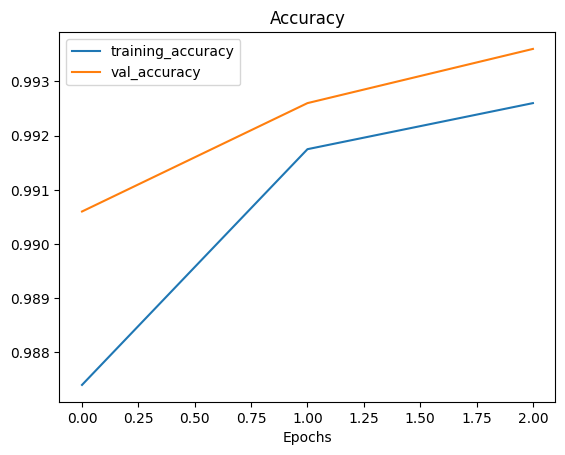

In [108]:
# plot loss and accuracies
plot_loss_acc_curves(history)

In [109]:
# save model for model evaluation
model.save('my_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
